# Calibration of stereo camera

Project Perception
Task 1 
As seen in week 4
(Run with NONBASE Python 3.10 64-bit)
- using Week 4 code

Usage:
- go into Running the code -> Parameters -> change what you need
- Run all 

Problems:
- Rectification lookin´ wanky
- draw lines undone
- tune parameters for better results

In [112]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
import time

In [113]:
rerun_calibration = False
rerun_undistortion = False
rerun_rectification = False
rerun_depth = True
path_calib = 'images/calibration/'
path = 'images/with_occlusion/'

In [114]:
#values from previous runs. Used if rerun_calib is set to false (needed in the next part)
K_left = np.array([[590.24505615, 0, 723.85543853], [
                  0, 700.56091309, 369.43859036], [0, 0, 1]])
K_right = np.array([[698.72259521, 0, 648.50704794], [
                   0, 698.6318967, 374.0875587], [0, 0, 1]])
dist_left = np.array([[-3.29479763e-01, 1.41779367e-01, -
                      1.15867147e-04, 2.53566722e-04, -3.10092346e-02]])
dist_right = np.array([[-3.25580109e-01, 1.39151479e-01, -
                     2.55229666e-04, 4.20203965e-04, -3.19659112e-02]])
mtx_left = np.array([[701.57106384,0,620.1497902],[0,701.53525002,369.95242304],[0,0,1]])
mtx_right = np.array([[699.26893071,0,649.01413957],[0,699.60352684,374.60780826],[0,0,1]])
roi = (0, 0, 1279, 719)

## Calibration

### Function

In [115]:
def calibration():

    # Write the image names
    images_left = glob.glob(path_calib+'original/left-*.png')
    images_right = glob.glob(path_calib+'original/right-*.png')
    assert images_left
    assert images_right

    # Implement the number of vertical and horizontal corners
    nb_vertical = 9
    nb_horizontal = 6

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nb_horizontal*nb_vertical, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints_left = []  # 2d points in image plane.
    imgpoints_right = []  # 2d points in image plane.

    for i in range(0,len(images_left)):

        # Load the image
        gray_left = cv2.cvtColor(cv2.imread(images_left[i]), cv2.COLOR_BGR2GRAY)
        gray_right = cv2.cvtColor(cv2.imread(images_right[i]), cv2.COLOR_BGR2GRAY)

        # Implement findChessboardCorners here
        ret_left, corners_left = cv2.findChessboardCorners(gray_left, (nb_vertical, nb_horizontal))
        ret_right, corners_right = cv2.findChessboardCorners(gray_right, (nb_vertical, nb_horizontal))

        # If found, add object points, image points (after refining them)
        if ret_left == True and ret_right==True:
            objpoints.append(objp)
            imgpoints_left.append(corners_left)
            imgpoints_right.append(corners_right)

    # Get the camera matrix
    _, mtx_left, dist_left, _, _ = cv2.calibrateCamera(objpoints, imgpoints_left, gray_left.shape[::-1], None, None)
    _, mtx_right, dist_right, _, _ = cv2.calibrateCamera(objpoints, imgpoints_right, gray_right.shape[::-1], None, None)
    K_left, roi_left = cv2.getOptimalNewCameraMatrix(mtx_left, dist_left, gray_left.shape[::-1], alpha=0)
    K_right, roi_right = cv2.getOptimalNewCameraMatrix(mtx_right, dist_right, gray_left.shape[::-1], alpha=0)
    print(gray_left.shape[::-1])
    _, K_left, dist_left, K_right, dist_right, R, T, E, F = cv2.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, K_left, dist_left, K_right, dist_right, gray_left.shape[::-1])
    return K_left, K_right, dist_left, dist_right, mtx_left, mtx_right, roi, objpoints, imgpoints_left, imgpoints_right, R, T, E, F

### Program

In [116]:
if rerun_calibration:
    K_left, K_right, dist_left, dist_right, mtx_left, mtx_right, roi, objpoints, imgpoints_left, imgpoints_right, R, T, E, F = calibration()
    print('K_left', K_left)
    print('K_right',K_right)
    print('dist_left',dist_left)
    print('dist_right',dist_right)
    print('mtx_left',mtx_left)
    print('mtx_right',mtx_right)
    print('roi - same for both',roi)
    print('R',R)
    print('T',T)
    print('E',E)
    print('F',F)

## UNDISTORTION

### Function

In [117]:
def undistort(side,mtx,dist,K,roi):
    if side == 'left':
        path_in = path+'original/left/*.png'
        path_out = path+'undistorted/left/left-'
    elif side == 'right':
        path_in = path+'original/right/*.png'
        path_out = path+'undistorted/right/right-'

    images = glob.glob(path_in)
    assert images

    i = 0
    for fname in images:
        # undistort
        img = cv2.imread(fname)
        dst = cv2.undistort(img, mtx, dist, None, K)

        # crop the image
        x, y, w, h = roi
        dst = dst[y:y+h, x:x+w]

        # save image
        cv2.imwrite(path_out+str(i)+'.png', dst)
        i += 1

    print("Undistortion "+side+ " done")

### Program

In [118]:
if rerun_undistortion:
    undistort('left',mtx_left,dist_left,K_left, roi)
    undistort('right',mtx_right,dist_right,K_right, roi)

## Rectification

### Rectification function


In [119]:
def draw_lines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    (r, c) = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 2)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

def epipolar_lines(gray_left, gray_right, debug):
    # Create a sift detector
    sift = cv2.SIFT_create()

    # Find the keypoints and descriptors with SIFT
    kp_left, des_left = sift.detectAndCompute(gray_left, None)
    kp_right, des_right = sift.detectAndCompute(gray_right, None)

    # Match points
    matches = cv2.BFMatcher().match(des_left, des_right)
    matches = sorted(matches, key=lambda x: x.distance)
    nb_matches = 200  # Using 200 best matches
    good = []
    pts1 = []
    pts2 = []
    for m in matches[:nb_matches]:
        good.append(m)
        pts1.append(kp_left[m.queryIdx].pt)
        pts2.append(kp_right[m.trainIdx].pt)
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)

    # Get fundamental matrix
    F, mask = cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC)

    # Remove outliers
    pts1 = pts1[mask.ravel() == 1]
    pts2 = pts2[mask.ravel() == 1]

    # Draw lines
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
    lines1 = lines1.reshape(-1, 3)
    epilines_left, keypoints_left = draw_lines(gray_left, gray_right, lines1, pts1, pts2)
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
    lines2 = lines2.reshape(-1, 3)
    epilines_right, keypoints_right = draw_lines(gray_right, gray_left, lines2, pts2, pts1)

    if debug:
        fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 10))
        axs[0].imshow(epilines_left)
        axs[0].set_title('left epipolar lines')
        axs[1].imshow(epilines_right)
        axs[1].set_title('right epipolar lines')
        plt.show()
        
    return F,pts1,pts2

def rectify(img_left, img_right, K_left, dist_left, K_right, dist_right, R, T, E, F,debug=False):
    '''
    Function that we used in project week 4, but the rectification is incorrect
    '''

    # Change to grayscale
    
    #F,_,_= epipolar_lines(gray_left, gray_right, debug)

    # Find projection essential matrix E
    #E = K_left.T@F@K_right
    #R_right, _, t_right = cv2.decomposeEssentialMat(E)
    # R_left = np.identity(3)
    # t_left = np.zeros(shape=(3,1))
    # P_left = np.hstack((K_left@R_left, K_left@t_left))
    # P_right = np.hstack((K_right@R_right, K_right@t_right))

    
    R_left, R_right, P_left, P_right, Q, roi_left, roi_right = cv2.stereoRectify(K_left, dist_left, K_right, dist_right, gray_left.shape[::-1], R,T,flags=cv2.CALIB_ZERO_DISPARITY,alpha=0)
    #TODO: Look at Q: disparity to depth matching matrix

    print(gray_left.shape[::-1]*5)

    # Rectify images
    leftMapX, leftMapY = cv2.initUndistortRectifyMap(K_left, dist_left, R_left, P_left, gray_left.shape[::-1], cv2.CV_32FC1)
    left_rectified = cv2.remap(gray_left, leftMapX, leftMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
    rightMapX, rightMapY = cv2.initUndistortRectifyMap(K_right, dist_right, R_right, P_right, gray_left.shape[::-1], cv2.CV_32FC1)
    right_rectified = cv2.remap(gray_right, rightMapX, rightMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

    return left_rectified, right_rectified


### Rectification

In [120]:
if rerun_rectification:

    # Read the undistorted images
    imagesL = glob.glob(path+'original/left/*.png')
    imagesR = glob.glob(path+'original/right/*.png')
    assert imagesL
    assert imagesR

    # Create a sift detector
    sift = cv2.SIFT_create()

    i = 0
    for i in range(0, len(imagesL)):
        gray_left = cv2.cvtColor(cv2.imread(imagesL[i]), cv2.COLOR_BGR2GRAY)
        gray_right = cv2.cvtColor(cv2.imread(imagesR[i]), cv2.COLOR_BGR2GRAY)
        left_rectified, right_rectified = rectify(gray_left, gray_right, K_left, dist_left, K_right, dist_right, R, T, E, F, debug=False) 
        epipolar_lines(left_rectified,right_rectified, debug=True)

        # Save images into folder
        cv2.imwrite(path+'rectified/left/left-'+str(i)+'.png', left_rectified)
        cv2.imwrite(path+'rectified/right/right-'+str(i)+'.png', right_rectified)
        i += 1

print("Rectification done")


Rectification done


## Image Depth

### Function


In [121]:
def depth_map(debug):
     # Read the rectified images
    imagesL = glob.glob(path+'rectified/left/*.png')
    imagesR = glob.glob(path+'rectified/right/*.png')
    assert imagesL
    assert imagesR

    i = -1
    while True:
        i+=1
        img_left = cv2.imread(path+'rectified/left/left-'+str(i)+'.png')
        img_right = cv2.imread(path+'rectified/right/right-'+str(i)+'.png')
        gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

        if debug:
            f, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18, 18))
            ax_left.imshow(gray_left,cmap='gray')
            ax_right.imshow(gray_right,cmap='gray')
            plt.show()

        min_disp = 7  # 7
        num_disp = 3*16  # 3*16
        block_size = 9  # 5, 11
        stereo = cv2.StereoBM_create(numDisparities=num_disp, blockSize=block_size)
        stereo.setMinDisparity(min_disp)
        stereo.setDisp12MaxDiff(200)  # 200
        stereo.setUniquenessRatio(1)  # 1
        stereo.setSpeckleRange(10)  # 3
        stereo.setSpeckleWindowSize(1)  # 3
        disp = stereo.compute(gray_left, gray_right).astype(np.float32) / 16.0

        # save image
        cv2.imwrite(path+'depth/img-'+str(i)+'.png', disp)

        if debug:
            f, (ax_left, ax_middle, ax_right) = plt.subplots(1, 3, figsize=(18, 18))
            ax_left.imshow(gray_left,cmap='gray')
            ax_middle.imshow(gray_right,cmap='gray')
            ax_right.imshow(disp,cmap='gray')
            plt.show()

### Program


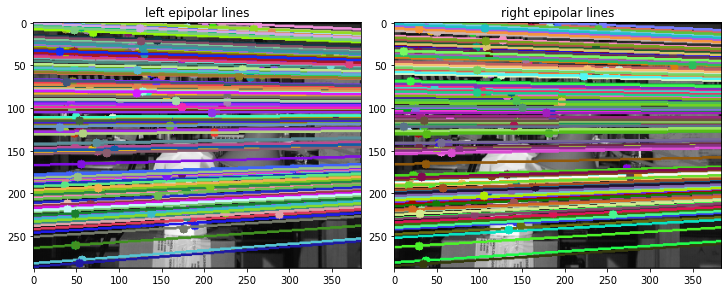

In [122]:
depth_map(debug=False) if rerun_depth else print("Depth not run")

# Backup Code

In [123]:
def rectify_old(img_left, img_right, debug=False):
    '''
    Function that we used in project week 4, but the rectification is incorrect
    '''

    # Change to grayscale
    gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    F,_,_= epipolar_lines(gray_left, gray_right, debug)

    # Find projection essential matrix E
    E = K_left.T@F@K_right
    R_right, _, t_right = cv2.decomposeEssentialMat(E)
    R_left = np.identity(3)
    t_left = np.zeros(shape=(3,1))
    P_left = np.hstack((K_left@R_left, K_left@t_left))
    P_right = np.hstack((K_right@R_right, K_right@t_right))
    cv2.stereoRectify(K_left, dist_left, K_right,
                        dist_right, img_left.shape[:2], R_right,t_right)

    # Rectify images
    (h,w,_) = img_left.shape
    leftMapX, leftMapY = cv2.initUndistortRectifyMap(K_left, dist_left, R_left, P_left, (w, h), cv2.CV_32FC1)
    left_rectified = cv2.remap(gray_left, leftMapX, leftMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
    rightMapX, rightMapY = cv2.initUndistortRectifyMap(K_right, dist_right, R_right, P_right, (w, h), cv2.CV_32FC1)
    right_rectified = cv2.remap(gray_right, rightMapX, rightMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

    return left_rectified, right_rectified

def rectify_uncalibrated(img_left, img_right, debug=False):
    '''
    Following steps from the web https://www.andreasjakl.com/understand-and-apply-stereo-rectification-for-depth-maps-part-2/
    '''

    # Change to grayscale
    gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    F,pts1,pts2= epipolar_lines(gray_left, gray_right, debug)

    # Find Homography (A homography matrix maps a point to a point, while the essential matrix maps a point to a line.)
    h1, w1 = gray_left.shape
    h2, w2 = gray_right.shape
    _, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1))

    # Rectify images
    left_rectified = cv2.warpPerspective(gray_left, H1, (w1, h1))
    right_rectified = cv2.warpPerspective(gray_right, H2, (w2, h2))

    return left_rectified, right_rectified

def calibration_old(side):

    if side=='left': path_in = path_calib+'original/left-*.png'
    elif side=='right': path_in = path_calib+'original/right-*.png'
    else: assert True

    # Implement the number of vertical and horizontal corners
    nb_vertical = 9
    nb_horizontal = 6

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nb_horizontal*nb_vertical, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints_left = []  # 2d points in image plane.

    images = glob.glob(path_in)
    assert images

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Implement findChessboardCorners here
        ret, corners = cv2.findChessboardCorners(
            gray, (nb_vertical, nb_horizontal))

        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            imgpoints_left.append(corners)

    # get the camera matrix
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints_left, gray.shape[::-1], None, None)
    print(rvecs, tvecs)
    # just to get dimensions, should be same for all images to come
    get_dim = cv2.imread(path_calib+'original/left-0000.png')
    h,  w = get_dim.shape[:2]
    K, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), alpha=0)
    print(roi)
    return K, dist, mtx, roi

In [124]:
if False:#rerun_rectification

    ##### UNCALIBRATED RECTIFICATION ######
    # https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#gaadc5b14471ddc004939471339294f052
    # all we need is F + undistorted images
    # does not know the intrinsic parameters, is not as accurate as calibrated version

    # Read the undistorted images
    imagesL = glob.glob(path+'undistorted/left/*.png')
    imagesR = glob.glob(path+'undistorted/right/*.png')
    assert imagesL
    assert imagesR

    # Create a sift detector
    sift = cv2.SIFT_create()

    i = 0
    for i in range(0, len(imagesL)):
        img_left = cv2.imread(imagesL[i])
        img_right = cv2.imread(imagesR[i])
        left_rectified, right_rectified = rectify2(img_left, img_right, debug=False) 
        epipolar_lines(left_rectified,right_rectified, debug=False)

        # Save images into folder
        cv2.imwrite(path+'rectified/left/left-'+str(i)+'.png', left_rectified)
        cv2.imwrite(path+'rectified/right/right-'+str(i)+'.png', right_rectified)
        i += 1

In [125]:
if False:
    K_left, dist_left, mtx_left,roi = calibration(side='left')
    K_right, dist_right, mtx_right,roi = calibration(side='right')